<a href="https://colab.research.google.com/github/taguatero/GOb/blob/master/Caso_de_las_bicicletas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalar los paquetes que se utilizarán en este código

In [1]:
install.packages("stargazer")
install.packages("FNN")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



##Generamos la función que nos permitirá obtener los datos alojados en google drive.

In [2]:
cargar_archivo_google_drive <- function(url_de_g_drive){
    g_link = url_de_g_drive
    file_id = substr(g_link, regexpr("/d/", g_link) + 3 ,  regexpr("/view", g_link) -1 )
    url =  paste("https://drive.google.com/uc?export=download&id=", file_id, sep="")
    download.file(url, "bikes.csv")
    datos <- read.table('bikes.csv',
                   sep=',',
                   header=T,
                   dec='.',
                   na.strings = "NA")
    return(datos)
}

## Cargamos los datos que utilizaremos junto a las librerías

In [3]:
library(FNN)  # Cargamos la/s librerías que necesitamos utilizar.
library(stargazer) #esta librería tiene una función que permite mostrar de manera elegante los resultados de regresiones.
datos=cargar_archivo_google_drive("https://drive.google.com/file/d/1O-PiTHt36pPdkdCasSxsLPDc-oowb1uh/view") # cargamos los datos que se encuentran en google drive
attach(datos) # atachamos las variables del data frame en R.
              # facilita que puedas "llamar" a las variables por su nombre



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 





#### Diccionario de variables:
instant: record index
* dteday : date
* season : season (1:winter, 2:spring, 3:summer, 4:fall)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* hr : hour (0 to 23)
* holiday : weather day is holiday (1) or not (0).
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit:
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered


No utilizamos un data set de TEST en este ejercicio porque sólo nos interesa
seleccionar modelo (elegir un valor razonable para 'k'). Eventualmente también
podríamos estar interesados en estimar el ecm del modelo seleccionado, en ese
caso antes de comenzar necesitamos separar una parte de los datos como conjunto de test.


# k-vecinos y Validation Set Approach:    


[1] 731

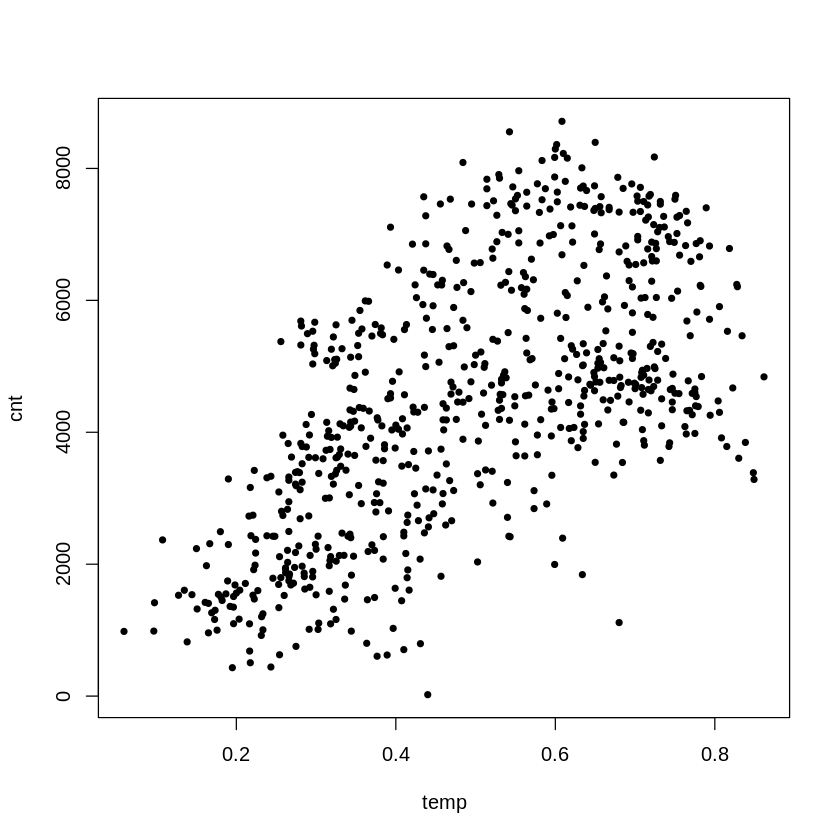

[1] 21

valores.k,,
1,15.12149,12.66219
6,14.60940,12.44676
11,14.59134,12.44655
16,14.57687,12.50507
21,14.55452,12.51398
26,14.53926,12.48989
31,14.54059,12.35257
36,14.53867,12.30773
41,14.54341,12.41963
46,14.54632,12.45546


[1] 36

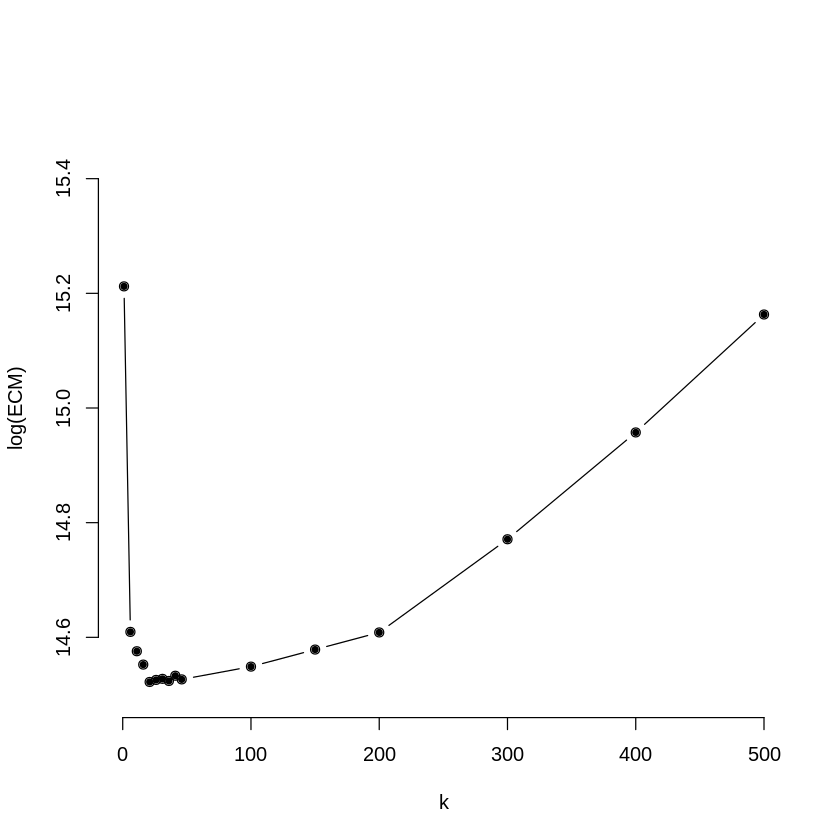

In [4]:
###################################################################################
plot(temp,cnt,pch=20) # Vamos a trabajar solo con 1 variable para poder visualizar!
#@ Vamos a construí­r un modelo predictivo para la demanda de bicis (cnt) en función de
#  la temperatura (para poder visualizar el fitting), luego agregamos mas co-variables.
###################################################################################
# (1) Separar los datos en TRAIN y VALIDACIÓN:
length(cnt) # 731 datos.
set.seed(321)
train.id = sample(731,500) # 500 obs train y 231 test.

train.X = matrix(temp[train.id],ncol=1)
train.Y = matrix(cnt[train.id],ncol=1)

test.X = matrix(temp[-train.id],ncol=1)
test.Y = matrix(cnt[-train.id],ncol=1)

#@@@ Estimación del hiper--parámetro "k":
valores.k = c(seq(1,50,by=5),100,150,200,300,400,500)
ECM = c() # AquÃ­ guardaremos los ECM
for(i in 1:length(valores.k)){
  kNN.Univ = knn.reg(train = train.X ,
                     test = test.X,
                     y = train.Y ,
                     k = valores.k[i]) # <- mira esta lÃ­nea!
  ECM[i] = sum( (test.Y - kNN.Univ$pred)^2 ) / 231
}

# Log del ecm estimado con conjunto de validación vs. "k"
plot(valores.k,log(ECM) ,type='b',pch=20, main='', xlab = 'k', ylim = c(14.5,15.5), bty = 'n')
valores.k[which(ECM == min(ECM))] # k* = 21 (aprendido por Val-Set approach).

##################### "5--fold cross validation:") #####################
# Creo una variable que indica a que fold pertenece cada dato:
fold.id <- cut(seq(1,731),breaks=5,labels=FALSE)

set.seed(1)
fold.id <- sample(fold.id, size = 731, replace = FALSE)

ECM.prom = c(); #
ECM.sd = c();   # Para cada valor del parámetro computamos el sd del estimador del ECME
for(i in 1:length(valores.k)){ # i recorre los posibles valores del parámetro k.
  ECM.b = c()
  for(b in 1:5){ # b-recorre los folds
    index.train = which(fold.id!=b) # "b" recorre los folds.
    index.test  = which(fold.id==b)

  kNN.Univ = knn.reg(train = as.matrix(temp[index.train]) ,
                      test = as.matrix(temp[index.test]) ,
                         y = as.matrix(cnt[index.train]) ,
                         k = valores.k[i]) # i recorre valores del parámetro k
  ECM.b[b] = sum( (cnt[index.test] - kNN.Univ$pred)^2 ) / length(index.test)
}
  ECM.prom[i] = mean(ECM.b);
  ECM.sd[i]   = sd(ECM.b);
}

cbind(valores.k,log(ECM.prom),log(ECM.sd))
points(valores.k,log(ECM))
valores.k[which(ECM.prom == min(ECM.prom))] # k* = 46 (aprendido por 5 folds-VC).

## Se realiza una comparación con el modelo de regresión lineal


Regresión lineal con datos de entrenamiento
                        Dependent variable:    
                    ---------------------------
                                cnt            
-----------------------------------------------
temp                       6,425.800***        
                             (367.729)         
                                               
Constant                   1,333.091***        
                             (195.965)         
                                               
-----------------------------------------------
Observations                    500            
R2                             0.380           
Adjusted R2                    0.379           
Residual Std. Error    1,518.275 (df = 498)    
F Statistic          305.350*** (df = 1; 498)  
Note:               *p<0.1; **p<0.05; ***p<0.01


[1] 14.61554

[1] 14.53867

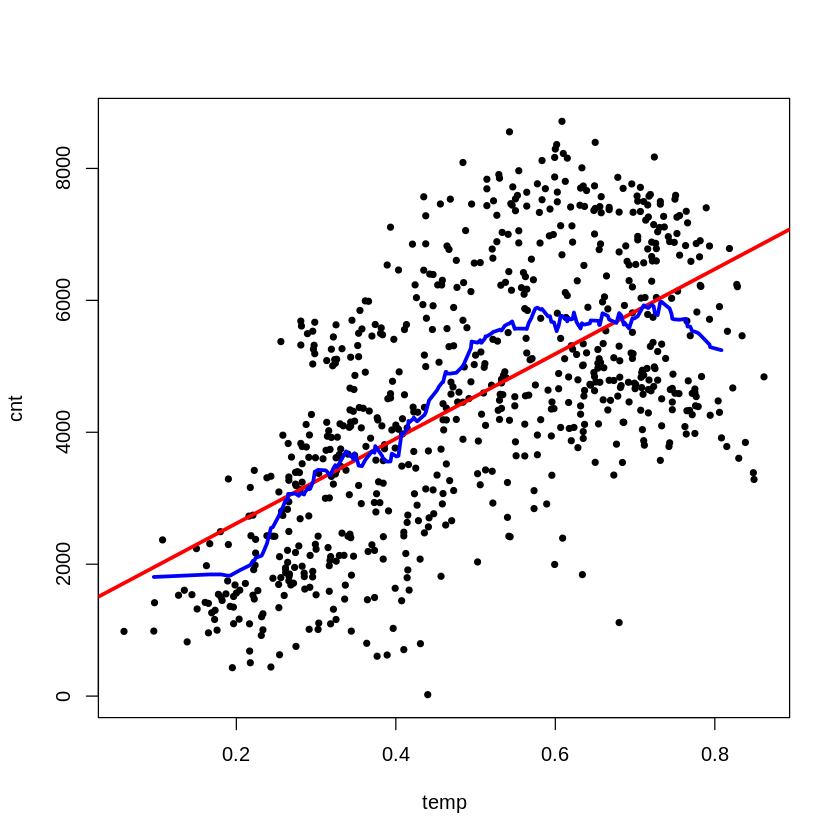

In [5]:
############################################################
# Modelo lineal (benchmark) vs Reg con k=46 vecinos:
cnt.reglin = lm(cnt~temp, subset = train.id)
stargazer(cnt.reglin,type="text",title="Regresión lineal con datos de entrenamiento") # sqrt(mse) en train = 1500
plot(temp,cnt,pch=20)
abline(cnt.reglin, col='red', lwd = 3)

kNN.k_46 = knn.reg(train = as.matrix(temp[train.id]) , test = as.matrix(temp[-train.id]),
                   y = as.matrix(cnt[train.id]), k = 46)
predicciones.ordenadas = cbind(temp[-train.id], kNN.k_46$pred)
predicciones.ordenadas = predicciones.ordenadas[order(predicciones.ordenadas[,1],
                                                      decreasing = TRUE),]
points(predicciones.ordenadas, type='l', col = 'blue', lwd = 3)

# Comparativas de ECM (escala logarí­tmica sobre conjunto de validaciÃ³n).
pred.cnt.reglin = predict(cnt.reglin, newdata = data.frame(temp = temp[-train.id]))
log(sum((pred.cnt.reglin - cnt[-train.id])^2  )/ 231)  # sqrt(ecm) fuera de la muestra.

min(log(ECM.prom))



# Incluí­r otros features la función de regresión de la demanda de bicicletas (explora la ayuda del comando knn.reg)


In [6]:
?knn.reg # para ver la documentación de la función.

##Observaremos las variables que podríamos incluir al modelo para hacer una predicción mejor.

In [7]:
str(datos)

'data.frame':	731 obs. of  16 variables:
 $ instant   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ dteday    : chr  "2011-01-01" "2011-01-02" "2011-01-03" "2011-01-04" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mnth      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ weekday   : int  6 0 1 2 3 4 5 6 0 1 ...
 $ workingday: int  0 0 1 1 1 1 1 0 0 1 ...
 $ weathersit: int  2 2 1 1 1 1 2 2 1 1 ...
 $ temp      : num  0.344 0.363 0.196 0.2 0.227 ...
 $ atemp     : num  0.364 0.354 0.189 0.212 0.229 ...
 $ hum       : num  0.806 0.696 0.437 0.59 0.437 ...
 $ windspeed : num  0.16 0.249 0.248 0.16 0.187 ...
 $ casual    : int  331 131 120 108 82 88 148 68 54 41 ...
 $ registered: int  654 670 1229 1454 1518 1518 1362 891 768 1280 ...
 $ cnt       : int  985 801 1349 1562 1600 1606 1510 959 822 1321 ...


Considero que los días laborales, las estaciones, la temperatura y el mes podrían ayudar

## Selecciono las variables que me interesarían realizar un gráfico de dispersión con la variable de interés.

In [8]:
ploteando=cbind(workingday, weekday, atemp, hum, season, temp, mnth, windspeed, weathersit)

## Se pasa a graficar las variables que consideramos que podrían influir en el alquiler de la bicicleta

[1] "Vamos a graficar la relación con distintas variables"

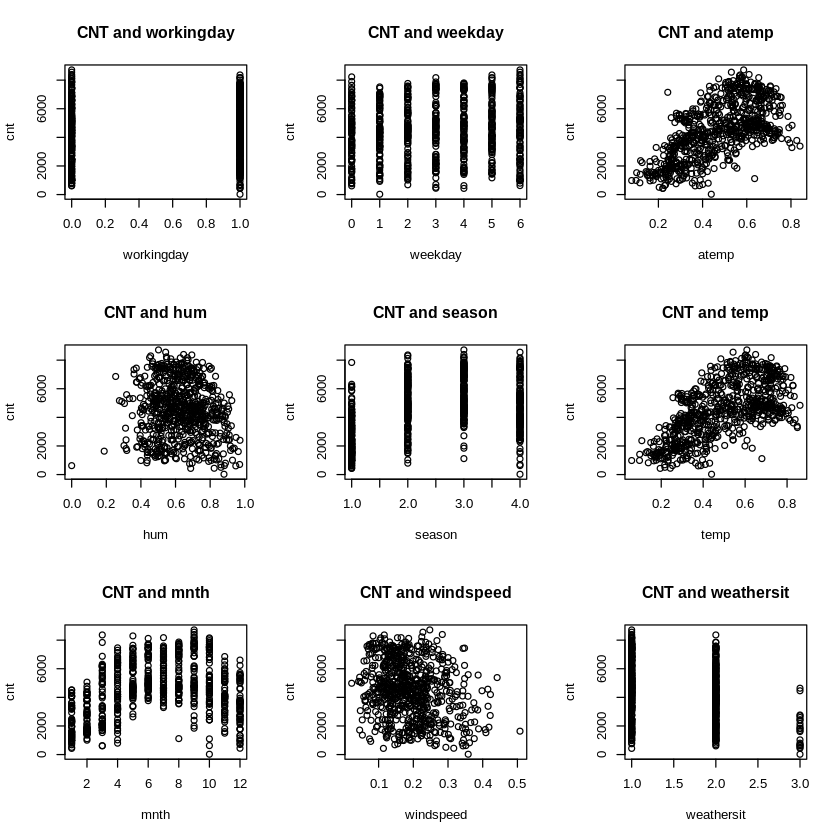

In [9]:
par(mfrow=c(3,3)) # Generamos un gr?fico que nos permita agrupar las 8 distribuciones de densidad.
nombres=colnames(ploteando)
paste("Vamos a graficar la relación con distintas variables")
for (i in 1:length(nombres)) {
  plot(cnt~ploteando[,i],
        main=paste("CNT and",sep=" ",nombres[i]),
        xlab=paste(nombres[i]))
}

## Selecciono las variables que me interesarían introducir al modelo.

In [10]:
mk=cbind(weekday,atemp, season, temp, mnth,windspeed,weathersit)

##Vuelvo a replicar el proceso pero incluyendo mas variables en comparación al primer ejemplo.

[1] 731

[1] 16

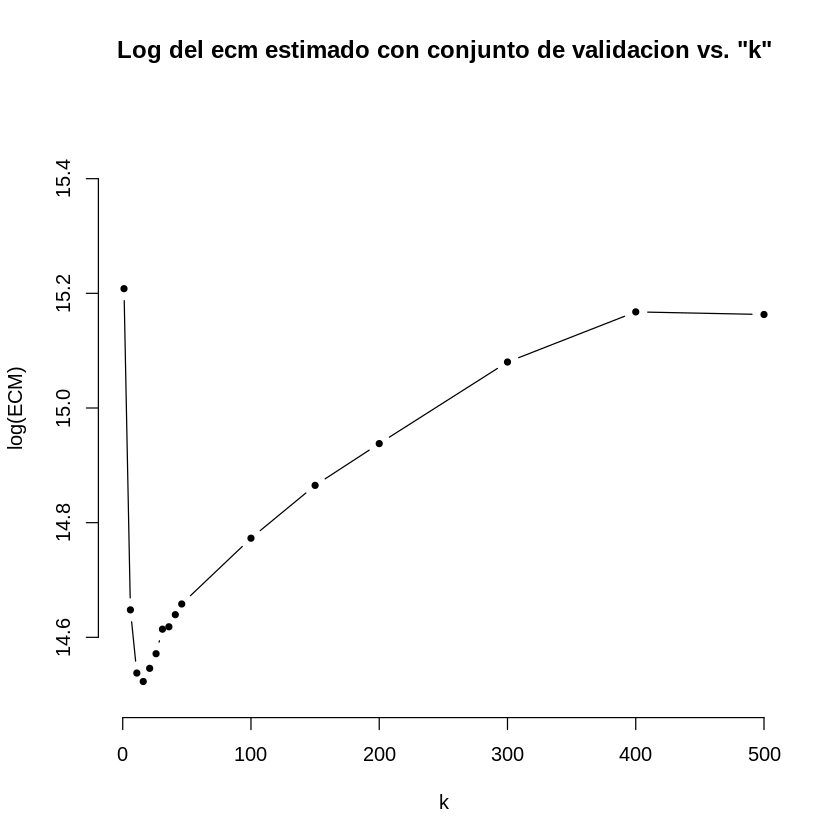

In [11]:
# (1) Separar los datos en TRAIN y VALIDACIÃN:
length(cnt) # 731 datos.
set.seed(321)
train.id = sample(731,500) # 500 obs train y 231 test.

mk.train.X = as.matrix(mk[train.id,])
train.Y = matrix(cnt[train.id],ncol=1)

mk.test.X = as.matrix(mk[-train.id,])
test.Y = matrix(cnt[-train.id],ncol=1)

#@@@ EstimaciÃ³n del hiper--parámetro "k":
valores.k = c(seq(1,50,by=5),100,150,200,300,400,500)
ECM = c() # AquÃ­ guardaremos los ECM
for(i in 1:length(valores.k)){
  kNN.Univ = knn.reg(train = mk.train.X ,
                     test = mk.test.X,
                     y = train.Y ,
                     k = valores.k[i]) # <- mira esta lÃ­nea!
  ECM[i] = sum( (test.Y - kNN.Univ$pred)^2 ) / 231
}

#
plot(valores.k,log(ECM) ,type='b',pch=20, main='Log del ecm estimado con conjunto de validacion vs. "k"', xlab = 'k', ylim = c(14.5,15.5), bty = 'n')

valores.k[which(ECM == min(ECM))] # k* = 16 (aprendido por Val-Set approach).

In [12]:
############################################################
########## 5--fold cross validation:   #####################
############################################################
# Creo una variable que indica a que fold pertenece cada dato:
fold.id <- cut(seq(1,731),breaks=5,labels=FALSE)
 # Conviene permutar de forma aleatoria los elementos de este vector.

set.seed(1)
fold.id <- sample(fold.id, size = 731, replace = FALSE)

ECM.prom = c(); # Para cada valor del parámetro computamos el promedio de 10 estimaciones del ECME
ECM.sd = c();   # Para cada valor del parámetro computamos el sd del estimador del ECME
for(i in 1:length(valores.k)){ # i recorre los posibles valores del parámetro k.
  ECM.b = c()
  for(b in 1:5){ # b-recorre los folds
    index.train = which(fold.id!=b) # "b" recorre los folds.
    index.test  = which(fold.id==b)
  kNN.Univ = knn.reg(train = as.matrix(mk[index.train,]) ,
                      test = as.matrix(mk[index.test,]) ,
                         y = as.matrix(cnt[index.train]) ,
                         k = valores.k[i]) # i recorre valores del parámetro k
  ECM.b[b] = sum( (cnt[index.test] - kNN.Univ$pred)^2 ) / length(index.test)
}
  ECM.prom[i] = mean(ECM.b);
  ECM.sd[i]   = sd(ECM.b)
}

cbind(valores.k,log(ECM.prom),log(ECM.sd))
paste("Valor de K que genera el ECM mas bajo")
valores.k[which(ECM.prom == min(ECM.prom))] # k* = 11 (aprendido por 5 folds-VC).


valores.k,,
1,15.05703,12.56366
6,14.50615,12.24373
11,14.45064,11.95326
16,14.50486,12.46804
21,14.50975,12.47414
26,14.52611,12.43531
31,14.56260,12.38830
36,14.58393,12.36513
41,14.60495,12.38171
46,14.61227,12.30555


[1] "Valor de K que genera el ECM mas bajo"

[1] 11

In [13]:
# Modelo lineal (benchmark):
cnt.reglin = lm(cnt~weekday + season + temp + mnth, subset = train.id)
stargazer(cnt.reglin,type="text",title="Regresión lineal benchmark") # sqrt(mse) en train = 1500

# modelo con k=50
kNN.k_50 = knn.reg(train = as.matrix(mk[train.id,]),
                   test = as.matrix(mk[-train.id,]),
                   y = as.matrix(cnt[train.id]), k = 50)
predicciones.ordenadas = cbind(cnt[-train.id], kNN.k_50$pred)
predicciones.ordenadas = predicciones.ordenadas[order(predicciones.ordenadas[,1],
                                                      decreasing = TRUE),]


Regresión lineal benchmark
                        Dependent variable:    
                    ---------------------------
                                cnt            
-----------------------------------------------
weekday                       35.339           
                             (33.225)          
                                               
season                      484.108***         
                             (119.148)         
                                               
temp                       5,641.555***        
                             (379.186)         
                                               
mnth                          -41.192          
                             (37.464)          
                                               
Constant                    671.079***         
                             (234.727)         
                                               
-----------------------------------------------
Observations

### A continuación se realiza la comparación entre el modelo que iteraba distintos valores de K vs el modelo de regresión lineal.



In [15]:
data=data.frame(mk[-train.id,]) #selecciono los datos de validación
# Comparativas de ECM (escala logarÃ­tmica sobre conjunto de validaciÃ³n).
pred.cnt.reglin = predict(cnt.reglin, newdata = data)

tabla=t(matrix(c("ECM de la regresión lineal junto a validación:     ",
        log(sum((pred.cnt.reglin - cnt[-train.id])^2  )/ 231),
        "ECM promedio de las iteraciones con distintos valores de K de 1:500:     ",
        min(log(ECM.prom)),
        "ECM del último modelo que se realizó con K= 50:     ",log(sum((kNN.k_50$pred - cnt[-train.id])^2)/ 231)),nrow=2))

paste("notar que el menor valor es mediante K=11")
tabla


[1] "notar que el menor valor es mediante K=11"

ECM de la regresión lineal junto a validación:,14.5040413731558
ECM promedio de las iteraciones con distintos valores de K de 1:500:,14.4506434023039
ECM del último modelo que se realizó con K= 50:,14.6803871127666
